In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [2]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

In [3]:
k = 1.38e-23
T = 300
q = 1.602e-19
V_T = k*T/q

# Photodiode
Cd = 150*1e-12
Id = 2*1e-6

<H2 style="text-align: center;"> Low-Noise Wideband Transimpedance Amplifier Design [June 2, 2021]</H2> 
<H3 style="text-align: center;"> Kevin Egedy</H3>

| Parameter                                             | Specification |
|:------------------------------------------------------|:--------------|
| Transimpedance gain (full signal path)                | $1$ $V/\mu A$ |
| Transimpedance bandwidth ($f_{3dB}$)                  | $1$ $MHz$     |
| Minimum photodiode current ($i_d$)                    | $2$ $\mu A$   |
| Photodiode capacitance ($C_d$)                        | $150$ $pF$    |
| Closed-loop gain magnitude peaking                    | $0$  $dB$     |
| $rms$ noise figure ($F = 1 + i_n^2/i_{ns}^2$)         | $\leq 0.5$ $dB$ |
| Power dissipation ($I_{DD} \cdot (V_{CC} + V_{EE}) $) | Optimize $mW$ |
| Cost-per-unit (1000 units)                            | Optimize $\$$ |

## Getting Started

[Transimpedance Amplifiers (TIA): Choosing the Best
Amplifier for the Job](https://www.tij.co.jp/jp/lit/an/snoa942a/snoa942a.pdf?ts=1622056332116&ref_url=https%253A%252F%252Fwww.google.com%252F) [November 2015–Revised May 2017]
- [Explore TI Transconductance Amplifiers](http://www.ti.com/lsds/ti/amplifiers/special-function-amplifiers/transconductance-amplifiers-products.page)
- [Transimpedance Considerations for High-Speed Amplifiers](http://www.ti.com/litv/pdf/sboa122)

<div font-size="8px">
<center><img src='img/noise-analysis-circuit.png'></center> 


$\begin{eqnarray}
&& i_{n,in} &=& \sqrt{{i_n}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2 + \frac{(e_n \cdot 2\pi f_{enb} C_{in})^2}{3}} \\[0.75em]
&& R_f &=& \sqrt{\frac{e_{n_{(FET)}}^2 - e_{n_{(BJT)}}^2}{{i_n}^2_{(BJT)}- {i_n}^2_{(FET)} + \frac{2\pi f_{enb}}{3} (C_{in_{(BJT)}} e_{n_{(BJT)}}^2 - C_{in_{(FET)}} e_{n_{(FET)}}^2) }}
\end{eqnarray}$
</div>


## Compare OPA657 (FET) and OPA846 (BJT) 
*Performance upgrade to OPA818 [MAY 2019]* 

| Name | GBW | $e_n$ | $i_n$ | $C_{in}$  |
|:-----|:---:|:---:|:---:|:----:|
|[OPA846](http://focus.ti.com/docs/prod/folders/print/opa846.html) (BJT)| 1750 MHz | 1.2 nV/$\sqrt{\text{Hz}}$| 2.8 pA/$\sqrt{\text{Hz}}$|150pF + 3.8pF = 153.8pF|
|[OPA657](http://focus.ti.com/docs/prod/folders/print/opa657.html) (FET)| 1600 MHz | 4.8 nV/$\sqrt{\text{Hz}}$| 1.3 fA/$\sqrt{\text{Hz}}$|150pF + 5.2pF = 155.2pF|
|[OPA818](https://www.ti.com/product/OPA818?qgpn=opa818) (FET)| 2700 MHz | 2.2 nV/$\sqrt{\text{Hz}}$| 3 fA/$\sqrt{\text{Hz}}$|150pF + 1.9pF = 151.9pF|

## TI: Continued
<div line-height="50%">
<center><img src='img/Bandwidth-vs-Gain.png'></center> 


"Using Equation 13 and comparing two amplifiers with very similar GBP—the OPA846 and the
OPA657—we can then **determine an appropriate transimpedance gain threshold**. Below this threshold, it
is preferable to use bipolar technology to achieve lower noise, while above the threshold it is better to use
FET technology ...

the total input-referred noise
generated by the OPA657 FET amplifier will be lower than that of the OPA846 bipolar amplifier for any
transimpedance gain greater than **2kΩ**.

FET-input operational amplifiers, such as the OPA657, are capable of higher transimpedance, where
decompensated bipolar operational amplifiers are capable of much higher bandwidth but are limited in
gain range."
</div>

## TI Continued: DC-Parameters Consideration

<center><img src='img/310kOhm_example.png'></center>


"The input bias current of the OPA846, 19μA, generates an output offset voltage with the feedback resistor
of 310kΩ of **5.89V**. Because the OPA846 is operating on a ±5V power supply, this offset voltage sends
the output into **saturation**. Adding a 310kΩ resistor on the noninverting input allows bias current
cancellation but now puts 5.89V common-mode voltage on the input, exceeding the common-mode input
range of the OPA846."

## Noise Threshold

| Parameter  | Specification |
|:-----------|:--------------|
| $rms$ noise figure | $\leq 0.5$ $dB$ |
| Minimum photodiode current ($i_d$) | $2$ $\mu A$ |

<hr>

$\begin{eqnarray}
&& F &=& 1 + i_{n,in}^2/i_{ns}^2 \\[0.5em]
&& i_{ns} &=& \sqrt{2qi_d} = 0.8 \text{ pA}/ \sqrt{Hz} \\[0.5em]
\end{eqnarray}$

<hr>
$\begin{eqnarray}
&& 0.5 &=& 10\log_{10}{\left(1 + i_{n,in}^2/i_{ns}^2\right)} \\[0.5em]
&& 1.122 &=& 1 + i_{n,in}^2/i_{ns}^2 \\[0.5em]
&& 1.122 &=& \frac{i_{ns}^2 + i_{n,in}^2}{i_{ns}^2} = \frac{i_{n,tot}^2}{i_{ns}^2}\\[0.5em]
&& i_{n,tot} &=& \sqrt{1.122 \cdot i_{ns}^2}\\[0.5em]
&& i_{n,tot} &=& 1.06 \cdot i_{ns} \\[0.5em]
&& i_{n,tot} &=& 0.85 pA /\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

## Noise Threshold Continued

$\begin{eqnarray}
&& \frac{v_o}{i_d} &=& R_f\dfrac{\omega_0^2}{s^2 + 2\zeta\omega_0 + \omega_0^2} \\[0.5em]
&& \dfrac{e_{na,in}}{e_{na}} &=& \left(1+\dfrac{Z_f}{Z_{in}}\right) = \dfrac{1+s(C_{in}+C_f)R_f}{1+sC_fR_f} \\[0.5em]
\end{eqnarray}$

<hr>

*Assume $e_{n,out}$ constant*

$\begin{eqnarray}
&& i_{n,tot} &=& 0.85 pA \\[0.5em]
&& \frac{e_{n,out}}{R_f} &\leq& 0.85 pA \\[0.5em]
&& e_{n,out} &=& \frac{v_o}{i_{n,tot}} i_{n,tot}\Bigg|_{R_f = 1000K} = 847 nV /\sqrt{\text{Hz}} \\[0.5em]
&& v_{n,out(rms)} &=& 847 nV /\sqrt{\text{Hz}} \cdot \sqrt{1 \text{ MHz}} = 847 uV\\[0.5em]
\end{eqnarray}$

In [42]:
filepath1 = 'data/OPA657.txt'
filepath2 = 'data/OPA846.txt'
filepath3 = 'data/OPA818A.txt'
df1 = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)
df3 = pd.read_csv(filepath3)
freq = df1['frequency']
onoise1 = df1['V(onoise)']
inoise1 = df1['V(r1)']
onoise2 = df2['V(onoise)']
inoise2 = df2['V(r1)']
onoise3 = df3['V(onoise)']
inoise3 = df3['V(r1)']

## Compare Technology Output Noise

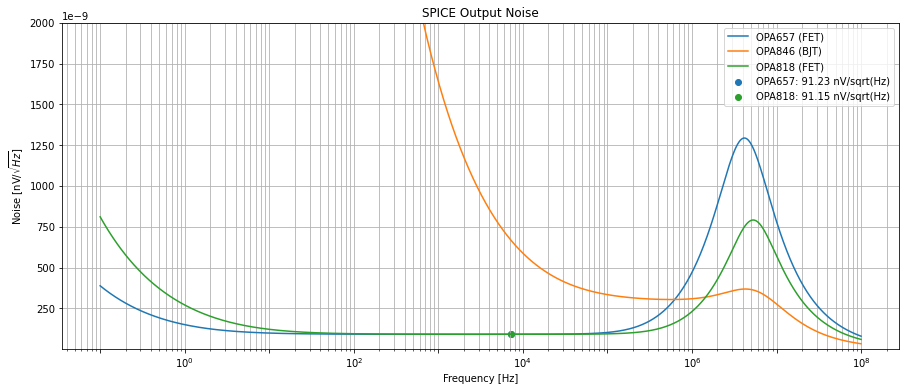

In [44]:
fig, ax = plt.subplots(1,figsize=(15,6))
x1 = np.argmin(10*np.log10(onoise3/inoise3))
label1 = f'OPA818: {round(onoise3[x1]*1e9,2)} nV/sqrt(Hz)'
label2 = f'OPA657: {round(onoise1[x1]*1e9,2)} nV/sqrt(Hz)'
ax.semilogx(freq, onoise1,label='OPA657 (FET)')
ax.semilogx(freq, onoise2,label='OPA846 (BJT)')
ax.semilogx(freq, onoise3,label='OPA818 (FET)')
ax.scatter(freq[x1],onoise1[x1],label=label2,color='tab:blue')
ax.scatter(freq[x1],onoise3[x1],label=label1,color='tab:green')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise [nV/$\sqrt{Hz}$]')
ax.set_title(r'SPICE Output Noise')
ax.ticklabel_format(style='sci', axis='y', scilimits=(-9,-9))
ax.set_ylim(1e-9,2000e-9)
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)
ax.legend()
plt.show();

Compare at 100K due to BJT saturation limits.

## Compare Technology Noise Figure

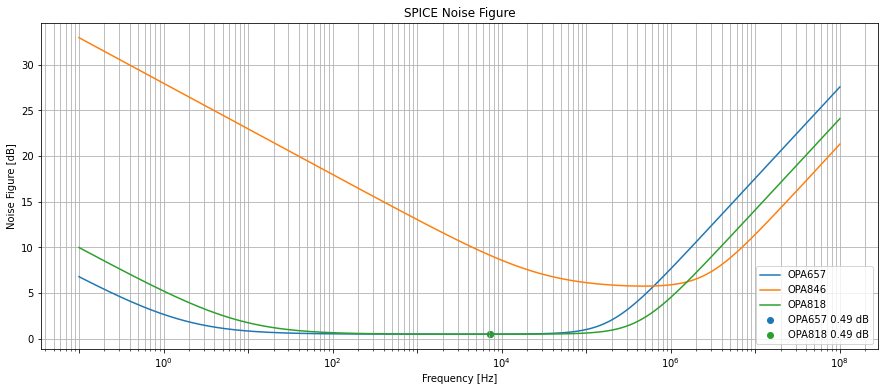

In [45]:
fig, ax = plt.subplots(1,figsize=(15,6))
x1 = np.argmin(10*np.log10(onoise3/inoise3))
label1 = f'OPA818 {round(min(10*np.log10(onoise3/inoise3)),2)} dB'
label2 = f'OPA657 {round(min(10*np.log10(onoise1/inoise1)),2)} dB'
ax.semilogx(freq, 10*np.log10(onoise1/inoise1),label='OPA657')
ax.semilogx(freq, 10*np.log10(onoise2/inoise2),label='OPA846')
ax.semilogx(freq, 10*np.log10(onoise3/inoise3),label='OPA818')
ax.scatter(freq[x1],10*np.log10(onoise1[x1]/inoise1[x1]),label=label2,color='tab:blue')
ax.scatter(freq[x1],10*np.log10(onoise3[x1]/inoise3[x1]),label=label1,color='tab:green')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise Figure [dB]')
ax.set_title(f'SPICE Noise Figure')
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)
ax.legend()
plt.show();

## TIA Gain

| Paramete   | Specification |
|:-----------|:--------------|
| Transimpedance gain (full signal path) | $1$ $V/\mu A$ |

<hr>

Desired gain is over 2$K\Omega$ threshold, use FET: [OPA818](https://www.ti.com/product/OPA818).

Compare noise at different gains such that $R_f = $ [10K, 100K, 1000K]

$\begin{eqnarray}
&& \frac{v_o}{i_d} &=& R_f\dfrac{\omega_0^2}{s^2 + 2\zeta\omega_0 + \omega_0^2} \\[0.5em]
\end{eqnarray}$

<center><img src='img/OPA818A.png' width=800></center>

## Noise Densities

$$\begin{eqnarray}
&&&&&& i_{n,in} &=& \sqrt{{i_{ns}}^2 + {i_{na}}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \leq 0.85 pA &&&&\\[0.5em]
\end{eqnarray}$$

<hr>

Photodiode Current Noise Density: $ i_{ns} = \sqrt{2qi_d} = 0.8 \text{ pA}/ \sqrt{Hz} $

<hr>

Op Amp Current Noise: $i_n = 3$ fA

<hr>

Input-Referred Thermal Noise Density: $\sqrt{\frac{4kT}{R_f}}$


| 100K   | | 1000K |
|:-------|-|:------|
|0.41 pA/$\sqrt{\text{Hz}}$ | | 0.13 pA/$\sqrt{\text{Hz}}$ |

<hr>

Input-Referred Op Amp Noise: $\frac{e_n}{R_f}$ and $e_n = 2.2$ nV

| 100K   | | 1000K |
|:-------|-|:------|
|0.022 pA/$\sqrt{\text{Hz}}$ | | 0.002 pA/$\sqrt{\text{Hz}}$ |

<hr>

Higher gain improves noise performance so choose $R_f = 1000K\Omega$.

In [52]:
filepath1 = 'data/OPA818A_Rf10K.txt'
filepath2 = 'data/OPA818A.txt'
filepath3 = 'data/OPA818A_Rf1000K.txt'
df1 = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)
df3 = pd.read_csv(filepath3)
freq = df1['frequency']
onoise1 = df1['V(onoise)']
inoise1 = df1['V(r1)']
onoise2 = df2['V(onoise)']
inoise2 = df2['V(r1)']
onoise3 = df3['V(onoise)']
inoise3 = df3['V(r1)']
freq3 = df3['frequency']

## Compare Rf Input-Referred Noise

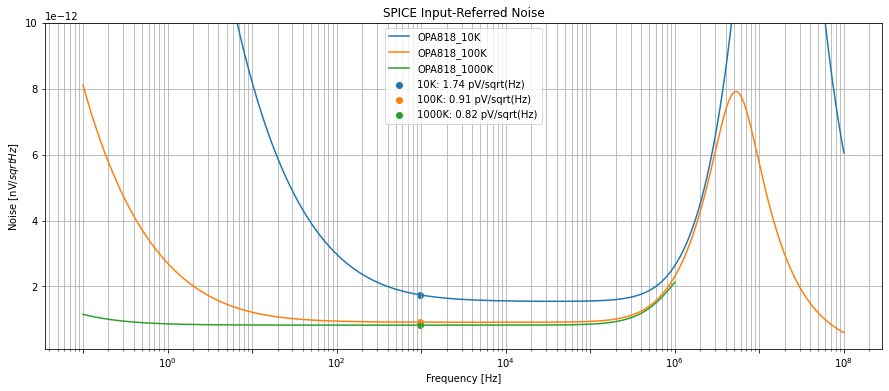

In [58]:
fig, ax = plt.subplots(1,figsize=(15,6))
x1 = np.argmin(10*np.log10(onoise3/inoise3))
label1 = f'10K: {round(onoise1[x1]/(10*1e3)*1e12,2)} pV/sqrt(Hz)'
label2 = f'100K: {round(onoise2[x1]/(100*1e3)*1e12,2)} pV/sqrt(Hz)'
label3 = f'1000K: {round(onoise3[x1]/(1000*1e3)*1e12,2)} pV/sqrt(Hz)'
ax.semilogx(freq, onoise1/(10*1e3),label='OPA818_10K')
ax.semilogx(freq, onoise2/(100*1e3),label='OPA818_100K')
ax.semilogx(freq3, onoise3/(1000*1e3),label='OPA818_1000K')
ax.scatter(freq[x1],onoise1[x1]/(10*1e3),label=label1,color='tab:blue')
ax.scatter(freq[x1],onoise2[x1]/(100*1e3),label=label2,color='tab:orange')
ax.scatter(freq3[x1],onoise3[x1]/(1000*1e3),label=label3,color='tab:green')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise [nV/$sqrt{Hz}$]')
ax.set_title(r'SPICE Input-Referred Noise')
ax.ticklabel_format(style='sci', axis='y', scilimits=(-12,-12))
ax.set_ylim(1e-13,10e-12)
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)
ax.legend()
plt.show();

## Compare Rf Noise Figure

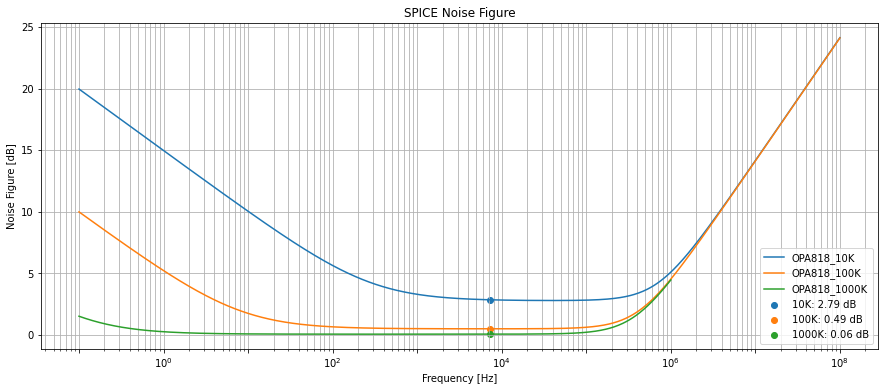

In [60]:
fig, ax = plt.subplots(1,figsize=(15,6))
x1 = np.argmin(10*np.log10(onoise2/inoise2))
label1 = f'10K: {round(min(10*np.log10(onoise1/inoise1)),2)} dB'
label2 = f'100K: {round(min(10*np.log10(onoise2/inoise2)),2)} dB'
label3 = f'1000K: {round(10*np.log10(onoise3[x1]/inoise3[x1]),2)} dB'
ax.semilogx(freq, 10*np.log10(onoise1/inoise1),label='OPA818_10K')
ax.semilogx(freq, 10*np.log10(onoise2/inoise2),label='OPA818_100K')
ax.semilogx(freq3, 10*np.log10(onoise3/inoise3),label='OPA818_1000K')
ax.scatter(freq[x1],10*np.log10(onoise1[x1]/inoise1[x1]),label=label1,color='tab:blue')
ax.scatter(freq[x1],10*np.log10(onoise2[x1]/inoise2[x1]),label=label2,color='tab:orange')
ax.scatter(freq3[x1],10*np.log10(onoise3[x1]/inoise3[x1]),label=label3,color='tab:green')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise Figure [dB]')
ax.set_title(f'SPICE Noise Figure')
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)
ax.legend()
plt.show();

## RMS Rf=1000K 
**OPA818**

| Parameter                 | Specification |
|:--------------------------|:--------------|
| Maximum input current ($i_{n,tot}$) | $\leq 0.85$ $pA$  |
| $rms$ noise  | $\leq 847$ $\mu V$ |


<hr>

<p style="text-align: center;"><b> Rf=1000K </b></p>
<center><img src='img/OPA818A_Rf1000K_RMS.png' width=300></center>

<hr>

Not quite there, need to address peaking at 1 MHz. 

$\begin{eqnarray}
&& \dfrac{e_{na,in}}{e_{na}} &=& \left(1+\dfrac{Z_f}{Z_{in}}\right) = \dfrac{1+s(C_{in}+C_f)R_f}{1+sC_fR_f} \\[0.5em]
\end{eqnarray}$




## Bootstrapped Cascode TIA

[Photodiode Front Ends: The Real Story](https://www.electrooptical.net/static/oldsite/www/frontends/frontends.pdf)

[Getting Photodetection Right by Phil Hobbs](https://electrooptical.net/static/oldsite/talks/GettingPDRight11.pdf)

[Philip Hobbs' Publications](https://www.osapublishing.org/opn/search.cfm?a=P%20HOBBS)

<center><img src='img/OPA818_A_bootstrap.png' width=800></center>

In [62]:
filepath1 = 'data/OPA846.txt'
filepath2 = 'data/OPA818A.txt'
filepath3 = 'data/OPA818A_bootstrap.txt'
df1 = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)
df3 = pd.read_csv(filepath3)
freq = df1['frequency']
onoise1 = df1['V(onoise)']
inoise1 = df1['V(r1)']
onoise2 = df2['V(onoise)']
inoise2 = df2['V(r1)']
onoise3 = df3['V(onoise)']
inoise3 = df3['V(r1)']
freq3 = df3['frequency']

## Bootstrap Cascode Input-Referred Noise

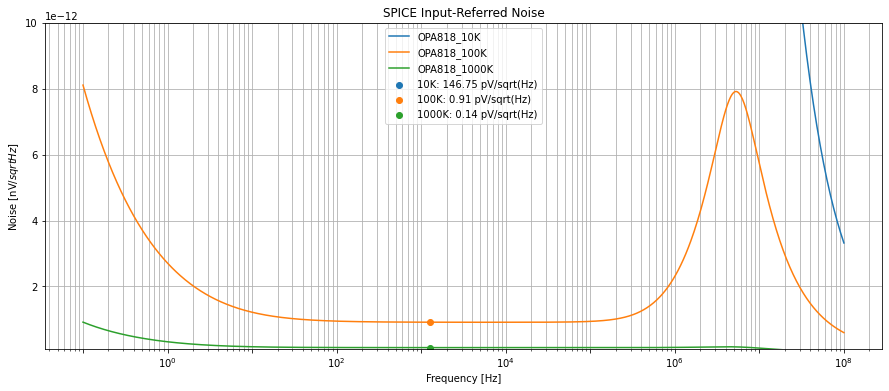

In [65]:
fig, ax = plt.subplots(1,figsize=(15,6))
x1 = np.argmin(10*np.log10(onoise3/inoise3))
label1 = f'10K: {round(onoise1[x1]/(10*1e3)*1e12,2)} pV/sqrt(Hz)'
label2 = f'100K: {round(onoise2[x1]/(100*1e3)*1e12,2)} pV/sqrt(Hz)'
label3 = f'1000K: {round(onoise3[x1]/(1000*1e3)*1e12,2)} pV/sqrt(Hz)'
ax.semilogx(freq, onoise1/(10*1e3),label='OPA818_10K')
ax.semilogx(freq, onoise2/(100*1e3),label='OPA818_100K')
ax.semilogx(freq3, onoise3/(1000*1e3),label='OPA818_1000K')
ax.scatter(freq[x1],onoise1[x1]/(10*1e3),label=label1,color='tab:blue')
ax.scatter(freq[x1],onoise2[x1]/(100*1e3),label=label2,color='tab:orange')
ax.scatter(freq3[x1],onoise3[x1]/(1000*1e3),label=label3,color='tab:green')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise [nV/$sqrt{Hz}$]')
ax.set_title(r'SPICE Input-Referred Noise')
ax.ticklabel_format(style='sci', axis='y', scilimits=(-12,-12))
ax.set_ylim(1e-13,10e-12)
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)
ax.legend()
plt.show();

In [13]:
filepath1 = 'data/OPA818A_ACanalysis.txt'
filepath2 = 'data/OPA818A_bootstrap_ACanalysis.txt'
#filepath3 = 'data/OPA657_ACanalysis.txt'
df1 = read_ltspice(filepath1,'ac')
df2 = read_ltspice(filepath2,'ac')
#df3 = read_ltspice(filepath3,'ac')
freq1 = df1['Freq.']
freq2 = df2['Freq.']
#freq3 = df3['Freq.']
mag1 = df1['Mag_V(vout)']
mag2 = df2['Mag_V(vout)']
#mag3 = df3['Mag_V(vout)']

## AC Response

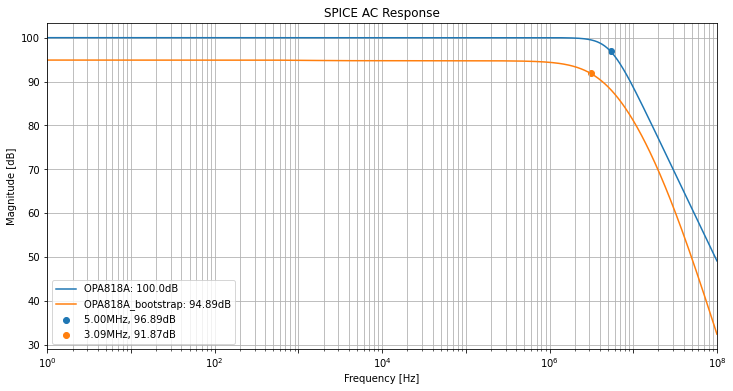

In [66]:
fig, ax = plt.subplots(1,figsize=(12,6))
x1 = np.where(mag1<=mag1[0]-3)[0][0]
label1 = "{:.2f}MHz, {:.2f}dB".format(round(freq1[x1]/1e6), mag1[x1])
x2 = np.where(mag2<=mag2[0]-3)[0][0]
label2 = "{:.2f}MHz, {:.2f}dB".format(freq2[x2]/1e6, mag2[x2])
#x3 = np.where(mag3<=mag3[0]-3)[0][0]
#label3 = "{:.2f}MHz, {:.2f}dB".format(freq3[x3]/1e6, mag3[x3])
ax.semilogx(freq1, mag1, color='tab:blue',label=f'OPA818A: {round(max(mag1),2)}dB')
ax.semilogx(freq2, mag2, color='tab:orange',label=f'OPA818A_bootstrap: {round(max(mag2),2)}dB')
#ax.semilogx(freq3, mag3, color='tab:green',label=f'OPA657: {round(max(mag3),2)}dB')
ax.scatter(freq1[x1],mag1[x1],label=label1,color='tab:blue')
ax.scatter(freq2[x2],mag2[x2],label=label2,color='tab:orange')
#ax.scatter(freq3[x3],mag3[x3],label=label3,color='tab:green')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title(f'SPICE AC Response')
ax.set_xlim(1e0,1e8)
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)
ax.legend()
plt.show();

## Price vs Power

| Name | Price ($) | Power (mW) | 
|:-----|:---:|:---:|
|[OPA657](http://focus.ti.com/docs/prod/folders/print/opa657.html) | 5.14 | TBD |
|[OPA818](https://www.ti.com/product/OPA818?qgpn=opa818) | 3.10 | TBD |

*Older generation OPA657 has greater price than OPA818, due to supply shortage most likely.

<H2 style="text-align: center;">  Thank you! </H2>